Question 1: Lasso

First, we will import our libraries and data, drop unwanted columns, and separate the data into the predicted variable (player salary) and the predictors/features (everything except player salary).

In [92]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Read in dataset
hitters = pd.read_csv('Hitters.csv')
# Remove players with null salary value
hitters = hitters[np.isnan(hitters.Salary)==False]
# Drop Mike Schmidt's data, because he was previously paid a very high salary and was
# very good but only had 20 at-bats that year due to injury
hitters = hitters.rename(columns={'Unnamed: 0':'Name'},inplace=False)
hitters = hitters[hitters.Name != '-Mike Schmidt']
# Drop non-numeric columns
hitters = hitters.drop(['Name','League','Division','NewLeague'],axis=1)
# Define array of features
X = hitters.drop(['Salary'],axis=1)
# Define column of outputs/dependent variables
Y = hitters.Salary

Next, we will calculate the coefficients/weights associated with each of the remaining features for each of 200 values of alpha in a lasso regression. For the lasso regularization, we are forced to raise the tolerance parameter to allow for the model to converge on the less penalized/underdamped/overfit iterations.

In [93]:
# Create list of alpha values that we are going to test
alpha_list1 = 10**np.linspace(3,-2,200)*0.5
# Save list of alpha values as a dict for use in cross-validation
alpha_list2 = {'alpha': alpha_list1}
# Define function that will perform Ridge regression, ensuring that the function normalizes all variables to the same scale
lasso = Lasso(normalize=True)

# Define empty list that will hold the features' weights at each alpha value during the ridge regression
weights1 = []
# For each alpha value that we're testing in the ridge regression...
for a in alpha_list1:
    # Calculate the weights assigned to each feature when that alpha value is in effect
    lasso.set_params(alpha = a, tol=0.07)
    lasso.fit(X,Y)
    # Append the weights associated with this alpha value to the list of all weights
    weights1.append(lasso.coef_)

After that, we plot each feature's coefficients over the range of alpha values that we sampled:

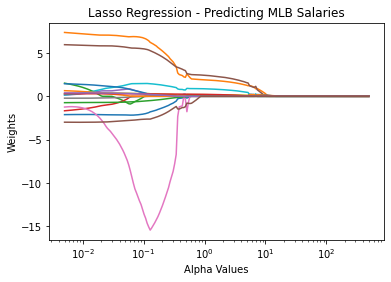

In [94]:
# Define plotting function
ax1 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax1.plot(alpha_list1,weights1)
# Set scale to logarithmic
ax1.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Weights')
plt.title('Lasso Regression - Predicting MLB Salaries')
plt.show()

Now we will identify the three features that the Lasso technique suggests that we retain. This is done by identifying which features maintain nonzero coefficients at the highest values of alpha. Because our weights are saved in an order corresponding to high-to-low alpha values, we can find the first instance in which at least 3 coefficients are nonzero:

In [95]:
# For each of the sets of weights...
for i in range(len(weights1)):
    # Save that alpha value's weights
    weight = weights1[i]
    if (len(weight[weight != 0])) >=3:
        print(weight)
        break

[0.         0.02137962 0.         0.         0.         0.
 0.         0.         0.         0.         0.14165031 0.10129283
 0.         0.         0.         0.        ]


The features with indices 1, 10, and 11 have coefficients outside the range. Let's print those feature names:

In [96]:
print('Final three remaining predictors are: ', X.columns[1], ',', X.columns[10], ', and', X.columns[11])

Final three remaining predictors are:  Hits , CRuns , and CRBI


Now, we will use cross-validation to find the optimal value of the regularization penalty i.e. alpha. First, we will calculate the negative mean squared error achieved by the model created with each alpha value.

In [97]:
# Create function that calculates the MSE for the weights associated with each alpha value under lasso regularization, using 5-fold cross-validation 
lasso_regressor = GridSearchCV(lasso, alpha_list2,scoring='neg_mean_squared_error', cv=5)
# Fit ridge regression model to our baseball salary data
lasso_regressor.fit(X,Y)
# Save MSE for each alpha value
MSEs1 = lasso_regressor.cv_results_['mean_test_score']

To help visualize the relationship between alpha and the mean squared error, we will plot them:

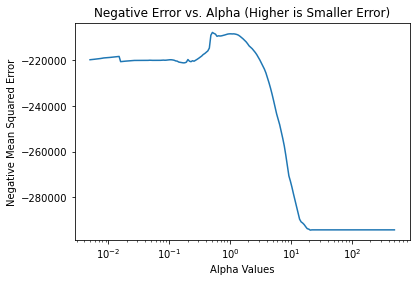

In [98]:
# Define plotting function
ax2 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax2.plot(alpha_list1,MSEs1)
# Set scale to logarithmic
ax2.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Negative Mean Squared Error')
plt.title('Negative Error vs. Alpha (Higher is Smaller Error)')
plt.show()

The alpha value with the optimal error is around 1, as the error stays pretty constant in that window. Plotting the full range of tested alpha values obscures the interesting part of the graph, so we will plot a subset:

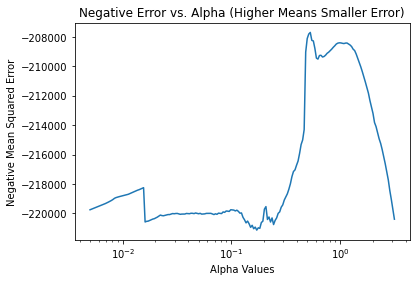

In [99]:
# Create list of alpha values that we are going to test
alpha_list3 = 10**np.linspace(.8,-2,200)*0.5
# Save list of alpha values as a dict for use in cross-validation
alpha_list4 = {'alpha': alpha_list3}

# Define empty list that will hold the features' weights at each alpha value during the ridge regression
weights2 = []
# For each alpha value that we're testing in the ridge regression...
for a in alpha_list3:
    # Calculate the weights assigned to each feature when that alpha value is in effect
    lasso.set_params(alpha = a)
    lasso.fit(X,Y)
    # Append the weights associated with this alpha value to the list of all weights
    weights2.append(ridge.coef_)

# Create function that calculates the MSE for the weights associated with each alpha value under ridge regularization, using 10-fold cross-validation 
lasso_regressor2 = GridSearchCV(lasso, alpha_list4,scoring='neg_mean_squared_error', cv=5)
# Fit ridge regression model to our baseball salary data
lasso_regressor2.fit(X,Y)
# Save MSE for each alpha value
MSEs2 = lasso_regressor2.cv_results_['mean_test_score']



# Define plotting function
ax3 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax3.plot(alpha_list3,MSEs2)
# Set scale to logarithmic
ax3.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Negative Mean Squared Error')
plt.title('Negative Error vs. Alpha (Higher Means Smaller Error)')
plt.show()

Now it is apparent that the alpha value for which the mean test error was minimal across the 5 cross-folds was between .01 and .1. Let's get the exact optimal value of the regularization penalty:

In [100]:
print('Alpha value corresponding to minimal MSE: ', str(lasso_regressor.best_params_['alpha']))

Alpha value corresponding to minimal MSE:  0.5117057010527264


Finally, we will display the weights for each feature that that alpha model suggests:

In [101]:
# Write function that calculates the absolute value of the difference between the alpha value
# alpha value that minimizes mean squared error
abs_diff = lambda list_value : abs(list_value - lasso_regressor.best_params_['alpha'])
# Find the alpha value that is closest to the alpha that minimizes mean squared error (should be equal)
closest = min(alpha_list1, key=abs_diff)
# Define index within list of alphas where that error-minimizing alpha value resides
mod_number = np.where(alpha_list1 == closest)[0][0]

weights_optimal1 = weights1[mod_number]

for i in range(len(X.columns)):
    print('Feature:', X.columns[i], ", Coefficient: ", str(weights_optimal1[i]))

Feature: AtBat , Coefficient:  -0.20375841426226424
Feature: Hits , Coefficient:  2.588207912507175
Feature: HmRun , Coefficient:  -0.0
Feature: Runs , Coefficient:  0.0
Feature: RBI , Coefficient:  0.0
Feature: Walks , Coefficient:  2.618648635861987
Feature: Years , Coefficient:  -1.774681669288985
Feature: CAtBat , Coefficient:  -0.0
Feature: CHits , Coefficient:  0.20586010213330325
Feature: CHmRun , Coefficient:  0.915717348892237
Feature: CRuns , Coefficient:  0.03972732048230944
Feature: CRBI , Coefficient:  0.006924005683319853
Feature: CWalks , Coefficient:  -0.0
Feature: PutOuts , Coefficient:  0.24562290548741847
Feature: Assists , Coefficient:  0.0
Feature: Errors , Coefficient:  -0.7848168730963202


Of the 16 predictors, the alpha value that produced the minimum mean error eliminated 6, leaving 10 nonzero coefficients and 10 features contributing to the model.

Question 2: Ridge

Because we already loaded the data for the first question, we can begin by calculating the coefficients/weights associated with each of the remaining features for each of 200 values of alpha in a ridge regression. 

In [102]:
# Create list of alpha values that we are going to test
alpha_list5 = 10**np.linspace(5,-5,200)*0.5
# Save list of alpha values as a dict for use in cross-validation
alpha_list6 = {'alpha': alpha_list5}
# Define function that will perform Ridge regression, ensuring that the function normalizes all variables to the same scale
ridge = Ridge(normalize=True)

# Define empty list that will hold the features' weights at each alpha value during the ridge regression
weights3 = []
# For each alpha value that we're testing in the ridge regression...
for a in alpha_list5:
    # Calculate the weights assigned to each feature when that alpha value is in effect
    ridge.set_params(alpha = a)
    ridge.fit(X,Y)
    # Append the weights associated with this alpha value to the list of all weights
    weights3.append(ridge.coef_)

After that, we plot each feature's coefficients over the range of alpha values that we sampled:

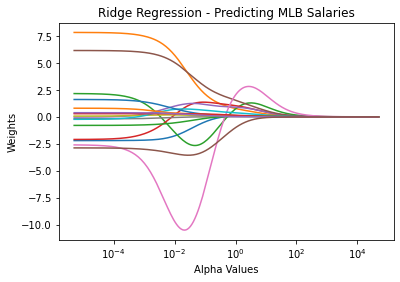

In [103]:
# Define plotting function
ax4 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax4.plot(alpha_list5,weights3)
# Set scale to logarithmic
ax4.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Weights')
plt.title('Ridge Regression - Predicting MLB Salaries')
plt.show()

Ridge presents a less straightforward path to feature selection than Lasso because, unlike in Lasso, the coefficients never equal exactly zero even as alpha becomes very high. However, to maintain the same structure as we used in the first problem, we will use -0.01 < x < 0.01 as our threshold and identify the three features that retain coefficients outside of that range for the highest alpha values. Because our weights are saved in an order corresponding to high-to-low alpha values, we can find the first instance in which at least 3 coefficients exceed the window:

In [104]:
# For each of the sets of weights...
for i in range(len(weights3)):
    # Save that alpha value's weights
    weight = weights3[i]
    if (len(weight[weight >= 0.01])) >=3:
        print(weight)
        break

[ 1.37632618e-03  4.99707191e-03  2.00989232e-02  8.44731502e-03
  8.91842753e-03  1.05044853e-02  4.28674633e-02  1.18106544e-04
  4.34808537e-04  3.27870111e-03  8.72333259e-04  9.00267807e-04
  9.51913662e-04  5.53130943e-04  9.02967410e-05 -4.28801817e-04]


The features with indices 2, 5, and 6 have coefficients outside the range. Let's print those feature names:

In [105]:
print('Final three remaining predictors are: ', X.columns[2], ',', X.columns[5], ', and', X.columns[6])

Final three remaining predictors are:  HmRun , Walks , and Years


Now, we will use cross-validation to find the optimal value of the regularization penalty i.e. alpha. First, we will calculate the negative mean squared error achieved by the model created with each alpha value.

In [106]:
# Create function that calculates the MSE for the weights associated with each alpha value under ridge regularization, using 10-fold cross-validation 
ridge_regressor = GridSearchCV(ridge, alpha_list6,scoring='neg_mean_squared_error', cv=5)
# Fit ridge regression model to our baseball salary data
ridge_regressor.fit(X,Y)
# Save MSE for each alpha value
MSEs3 = ridge_regressor.cv_results_['mean_test_score']

To help visualize the relationship between alpha and the mean squared error, we will plot them:

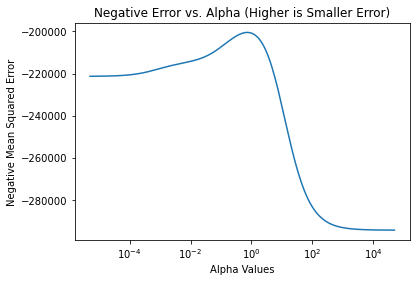

In [107]:
# Define plotting function
ax5 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax5.plot(alpha_list5,MSEs3)
# Set scale to logarithmic
ax5.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Negative Mean Squared Error')
plt.title('Negative Error vs. Alpha (Higher is Smaller Error)')
plt.show()

The alpha value with the smallest value is approximately 1. However, plotting the full range of tested alpha values obscures the interesting part of the graph, so we will plot a subset:

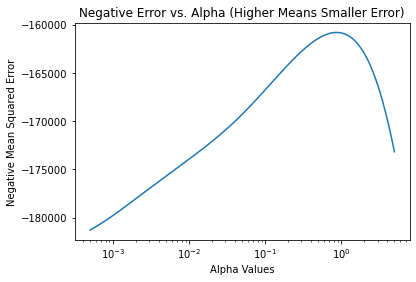

In [109]:
# Create list of alpha values that we are going to test
alpha_list7 = 10**np.linspace(1,-3,200)*0.5
# Save list of alpha values as a dict for use in cross-validation
alpha_list8 = {'alpha': alpha_list7}

# Define empty list that will hold the features' weights at each alpha value during the ridge regression
weights4 = []
# For each alpha value that we're testing in the ridge regression...
for a in alpha_list7:
    # Calculate the weights assigned to each feature when that alpha value is in effect
    ridge.set_params(alpha = a)
    ridge.fit(X,Y)
    # Append the weights associated with this alpha value to the list of all weights
    weights4.append(ridge.coef_)

# Create function that calculates the MSE for the weights associated with each alpha value under ridge regularization, using 10-fold cross-validation 
ridge_regressor2 = GridSearchCV(ridge, alpha_list8,scoring='neg_mean_squared_error', cv=10)
# Fit ridge regression model to our baseball salary data
ridge_regressor2.fit(X,Y)
# Save MSE for each alpha value
MSEs4 = ridge_regressor2.cv_results_['mean_test_score']



# Define plotting function
ax6 = plt.gca()
# Plot alpha values on x axis and each feature's weight on the y axis
ax6.plot(alpha_list7,MSEs4)
# Set scale to logarithmic
ax6.set_xscale('log')
# Pretty up the graph
plt.axis('tight')
# Label axes
plt.xlabel('Alpha Values')
plt.ylabel('Negative Mean Squared Error')
plt.title('Negative Error vs. Alpha (Higher Means Smaller Error)')
plt.show()

Now it is apparent that the alpha value for which the mean test error was minimal across the 10 cross-folds was just less than 1. Let's get the exact optimal value of the regularization penalty:

In [110]:
print('Alpha value corresponding to minimal MSE: ', str(ridge_regressor.best_params_['alpha']))

Alpha value corresponding to minimal MSE:  0.7496342163930221


Finally, we will display the weights for each feature that that alpha model suggests:

In [111]:
# Write function that calculates the absolute value of the difference between the alpha value
# alpha value that minimizes mean squared error
abs_diff = lambda list_value : abs(list_value - ridge_regressor.best_params_['alpha'])
# Find the alpha value that is closest to the alpha that minimizes mean squared error (should be equal)
closest = min(alpha_list5, key=abs_diff)
# Define index within list of alphas where that error-minimizing alpha value resides
mod_number2 = np.where(alpha_list5 == closest)[0][0]

weights_optimal2 = weights3[mod_number2]

for i in range(len(X.columns)):
    print('Feature:', X.columns[i], ", Coefficient: ", str(weights_optimal2[i]))

Feature: AtBat , Coefficient:  0.07351730446084824
Feature: Hits , Coefficient:  0.8570744749326284
Feature: HmRun , Coefficient:  0.42742957100941653
Feature: Runs , Coefficient:  1.0854422225591907
Feature: RBI , Coefficient:  0.9135238884059246
Feature: Walks , Coefficient:  1.653723699862348
Feature: Years , Coefficient:  1.4556631660551402
Feature: CAtBat , Coefficient:  0.011291886186100365
Feature: CHits , Coefficient:  0.056943785068832506
Feature: CHmRun , Coefficient:  0.39373375280020956
Feature: CRuns , Coefficient:  0.11493829014782947
Feature: CRBI , Coefficient:  0.118914770305349
Feature: CWalks , Coefficient:  0.05857982811401552
Feature: PutOuts , Coefficient:  0.1672799393453775
Feature: Assists , Coefficient:  0.031356360421143925
Feature: Errors , Coefficient:  -1.2551965718746383


**Question 3: Explain in your own words the bias-variance tradeoff. What role does regularization play in this tradeoff? Make reference to your findings in number (1) to describe models of high/low bias and variance.**

The bias-variance tradeoff is the tradeoff between 1) giving your model a lot of flexibility to fit to your training data but risking overfitting, and 2) giving your model less flexibility to fit to your training data but lowering the risk of overfitting. If you give your model more flexibility, the components of that model -- coefficients/weights -- will vary more when the observations included in your training set change. Consequently, the prediction generated by the model for a given new observation will also vary more. With this higher variance comes lower "bias", which really means training set bias: the model will track more closely to the actual classes/outcomes of the observations in the training set. However, if too much flexibility is allowed, this increased variance captures the noise of the training set in the model, and can lead to overfitting and worse predictions for the test set.

In the opposite case, if one gives the model less flexibility to fit to the training data, the "bias" -- training set bias -- will be higher: the model will track less closely to the actual classes/outcomes of the observations in the training set. With this decrease in flexibility comes a decrease in variance: adding or removing observations from the training set has less of an impact on the generated model, and the variability in the model's predictions for a given new observation are also lower. The idea of prioritizing a lower variance is trying to capture the general relationship between the features and outcome without including the data's noise. However, allowing for too much bias at the expense of avoiding overfitting runs the risk of missing true relationships between features and the dependent variable.

Regularization offers an opportunity to optimize this tradeoff. A model with higher-magnitude coefficients is a model with higher variance. In both Lasso and Ridge, a large number of models are trained, each of which generates optimal coefficients based on a balance between 1) error and 2) penalties for larger coefficients. The size of the penalty varies across the models, leading to models with different coefficient magnitudes, and therefore, variances. Models generated using smaller penalties have larger coefficients and larger variances; models generated using larger penalties have smaller coefficients (oftentimes set to zero) and smaller variances. After these sets of coefficients are created, all of the models are trained on training data and tested on testing data (either on a simple training-test split or via cross-validation). Each of the model's error rate on the test set(s) can be calculated, and the model with minimal error (minimal average error, if you're using cross-validation) is said to have coefficients with the best balance in the spectrum of the bias-variance tradeoff.

The above examples illustrate these points. In the Lasso case, the model with the lowest mean error had a coefficient magnitude punisher such that 6 of the variables had their coefficients pushed to 0. Including those features in the model was introducing variance that was hurting the model's ability to predict the salaries of new players; the decrease in bias was not worth the increase in variance. The ridge case is less concrete, because the coefficients don't go to precisely 0, but some of the statistics -- at bats and assists, for example -- had their coefficients pushed by the punisher to extremely small values in the model with minimal mean error. And all of the coefficients were smaller than they were in the totally unregularized version of the model. This shrinking was for the same reason: having larger coefficients overfits to the training data and introduces variance in predictions that hurts testing performance.